Generating a dataset ...
Training ...


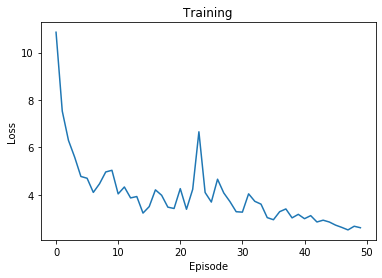

72 76 76 84]
[45 35 24 25 46 95 85 96 16  5] [ 5 16 24 25 35 45 46 85 95 96] [ 5 16 24 25 35 45 46 85 85 96]
[ 4 80 41 23 34 41 24  8 86 72] [ 4  8 23 24 34 41 41 72 80 86] [ 4  8 23 24 34 41 41 72 80 86]
[13 42 50 55  7 19  7 63 16 59] [ 7  7 13 16 19 42 50 55 59 63] [ 7  7 13 16 19 42 50 55 63 63]
[74 94 48 48 66  9 76  2 97 53] [ 2  9 48 48 53 66 74 76 94 97] [ 2  9 48 48 53 66 74 76 94 97]
[61 33 77 68 97  5 13 27 43 21] [ 5 13 21 27 33 43 61 68 77 97] [ 5 13 21 27 33 43 61 68 77 97]
[ 4  1 80 26 60  4 72 26  1 32] [ 1  1  4  4 26 26 32 60 72 80] [ 1  4  4  4 26 26 32 60 72 80]
[61 70  6 98 25 77 66 67 77 50] [ 6 25 50 61 66 67 70 77 77 98] [ 6 25 50 61 66 66 70 77 77 98]
[28 87 76 71 46 15 41 84 18  2] [ 2 15 18 28 41 46 71 76 84 87] [ 2 15 18 28 41 46 71 76 84 87]
[81 88 83 58 61 58 86 56 81  4] [ 4 56 58 58 61 81 81 83 86 88] [ 4 56 56 61 61 81 81 81 88 88]
[58 25 60 14 75 49 61 18  1 77] [ 1 14 18 25 49 58 60 61 75 77] [ 1 14 18 25 49 58 61 61 75 77]
[87 50 75 29 62 75 38 74 70

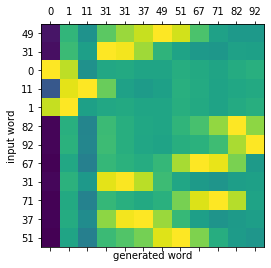

[30 10 14 77 52 46 50 41 77 26 55 34] [10 14 26 30 34 41 46 50 52 55 77 77] [10 14 26 30 34 41 46 50 55 55 77 77]

Attention matrix


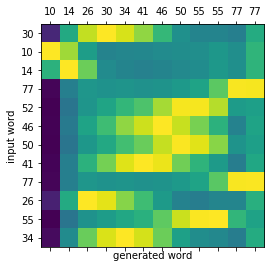

[33 91  8 97 93  2 83  2 32 12 85 33] [ 2  2  8 12 32 33 33 83 85 91 93 97] [ 2  8  8 12 32 33 33 83 85 91 91 97]

Attention matrix


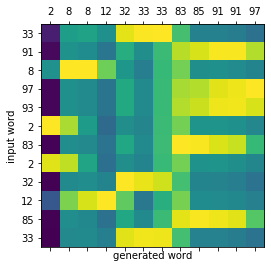

[10 86 63 39 86 70 16 59 62  6 59 49] [ 6 10 16 39 49 59 59 62 63 70 86 86] [ 6 10 16 39 49 59 63 63 63 70 86 86]

Attention matrix


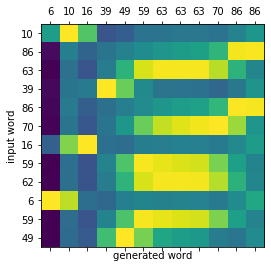

[54 62 99 24 27 65 26  9 89 24 59 63] [ 9 24 24 26 27 54 59 62 63 65 89 99] [ 9 24 24 27 27 54 59 65 65 65 89 99]

Attention matrix


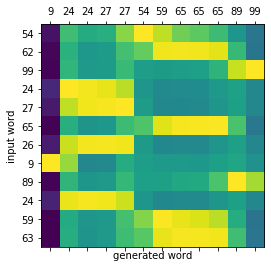

[30 37 75 22 27 35 96  1 48 81 49 59] [ 1 22 27 30 35 37 48 49 59 75 81 96] [ 1 22 27 30 35 37 48 49 59 75 81 96]

Attention matrix


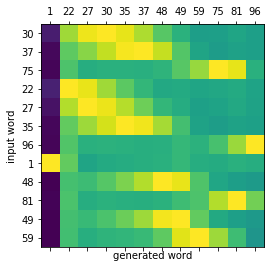

[22 47 40 47 10 45 57 12 24 22 50 51] [10 12 22 22 24 40 45 47 47 50 51 57] [10 12 22 24 24 40 40 45 47 51 51 57]

Attention matrix


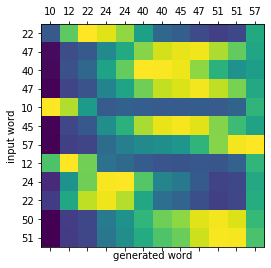

[86 43 53  8  6 39 65 99 91 75 16 56] [ 6  8 16 39 43 53 56 65 75 86 91 99] [ 6  8 16 39 43 53 56 65 75 86 91 99]

Attention matrix


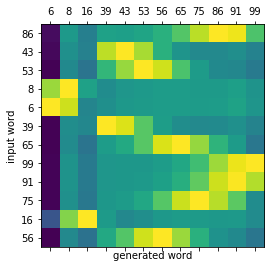

[80 87 79 90 48 84 46 26 11 64 59 49] [11 26 46 48 49 59 64 79 80 84 87 90] [11 26 46 48 49 59 64 79 79 80 87 90]

Attention matrix


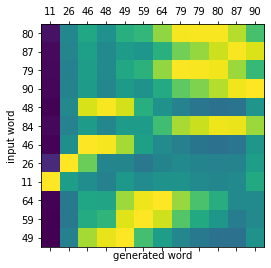

[49 42  8  4 22  0 61 36 84  5 17  8] [ 0  4  5  8  8 17 22 36 42 49 61 84] [ 0  4  8  8  8 17 22 36 42 49 61 84]

Attention matrix


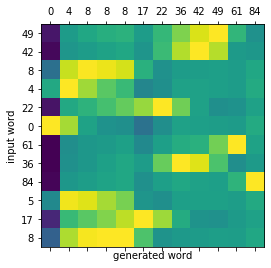

[72  5  1 48 54 50 75 86 18  9 83  3] [ 1  3  5  9 18 48 50 54 72 75 83 86] [ 1  3  5  9 18 48 50 54 72 75 83 86]

Attention matrix


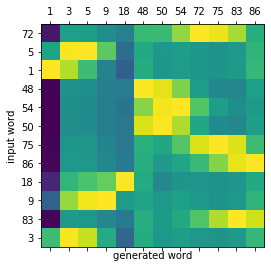

[55 67  5 47 13 50 56 13 48  6 46 17] [ 5  6 13 13 17 46 47 48 50 55 56 67] [ 5  6  6 13 17 46 46 50 55 55 56 67]

Attention matrix


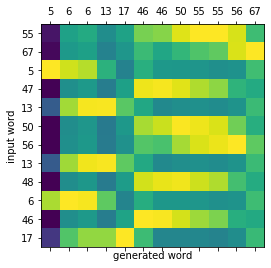

[95  8 94 63 41 13 32 84 70 51 80 36] [ 8 13 32 36 41 51 63 70 80 84 94 95] [ 8 13 32 36 41 51 63 70 80 84 95 94]

Attention matrix


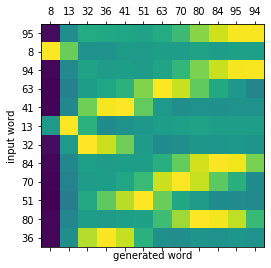

[22 31 39 25 78 72 66 60 99 91 85 16] [16 22 25 31 39 60 66 72 78 85 91 99] [16 22 25 31 39 60 66 72 78 85 91 99]

Attention matrix


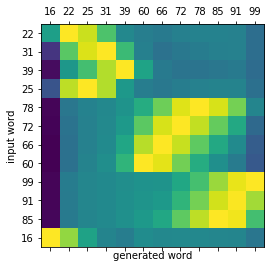

[69 96 68 83 87 48  5  8 26 96 44 91] [ 5  8 26 44 48 68 69 83 87 91 96 96] [ 5  8 26 44 48 68 69 83 87 91 91 96]

Attention matrix


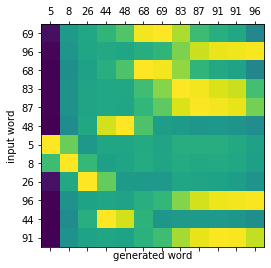

[93 13 12 27  0 33 89 23 88 18 76  0] [ 0  0 12 13 18 23 27 33 76 88 89 93] [ 0  0 12 13 18 23 27 33 76 88 88 93]

Attention matrix


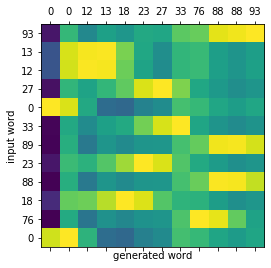

[86 73 46  9 91 93  0  2 77 34  6 16] [ 0  2  6  9 16 34 46 73 77 86 91 93] [ 0  2  6  9 16 34 46 73 77 86 91 93]

Attention matrix


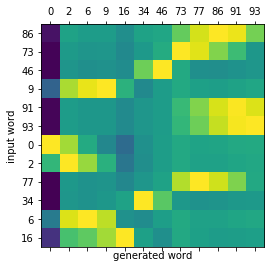

[56 65 68 21 73 45  2 52 44 86 16  4] [ 2  4 16 21 44 45 52 56 65 68 73 86] [ 2  4 16 21 44 45 52 56 65 68 73 86]

Attention matrix


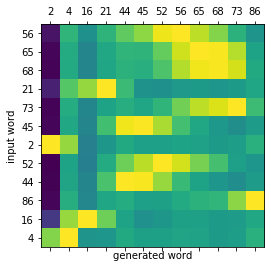

[10 56 15 27 94 60 42 61 60 54 70 55] [10 15 27 42 54 55 56 60 60 61 70 94] [10 15 27 42 54 54 60 61 61 61 70 94]

Attention matrix


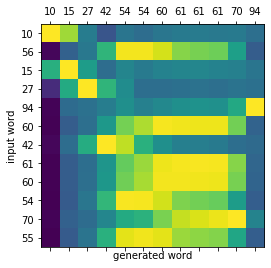

[29 73 61 77 62 73 46 45 42 97 84 26] [26 29 42 45 46 61 62 73 73 77 84 97] [26 29 42 42 46 61 62 73 77 77 84 97]

Attention matrix


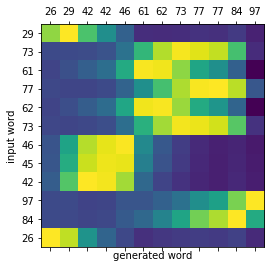

[40 28 11 49 10 29 17 51 22 11 89 17] [10 11 11 17 17 22 28 29 40 49 51 89] [10 11 11 17 22 22 28 29 40 49 51 89]

Attention matrix


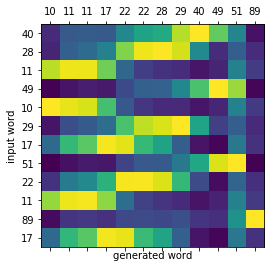

[88 75 82 57  2 18 32 60 11  7 37 59] [ 2  7 11 18 32 37 57 59 60 75 82 88] [ 2  7 11 18 32 37 57 60 60 75 82 88]

Attention matrix


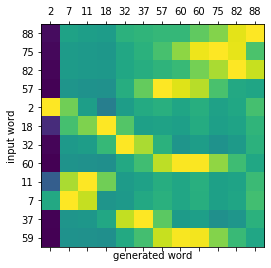

[22 66 58 22 56 47 40 62 15 54 45 44] [15 22 22 40 44 45 47 54 56 58 62 66] [15 22 22 40 40 44 47 54 56 62 66 66]

Attention matrix


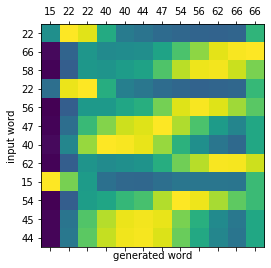

[89 20 92 84 68 53 36 84 53 14 14 21] [14 14 20 21 36 53 53 68 84 84 89 92] [14 14 20 21 36 53 53 68 84 84 92 92]

Attention matrix


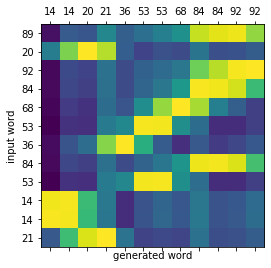

[15 61 41 81 81 94  9 30 30 27 66 52] [ 9 15 27 30 30 41 52 61 66 81 81 94] [ 9 15 27 30 30 41 52 61 66 81 81 94]

Attention matrix


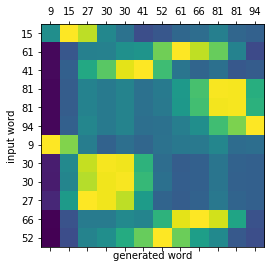

[58 43 84 39 26 63 21 47 82 55 25 43] [21 25 26 39 43 43 47 55 58 63 82 84] [21 25 26 39 43 43 47 55 63 63 82 84]

Attention matrix


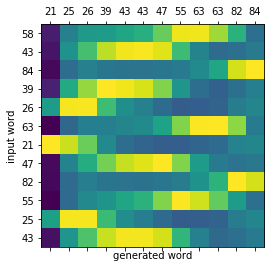

[54 66 13 83 89 25  9 29  5 97  8  4] [ 4  5  8  9 13 25 29 54 66 83 89 97] [ 4  8  9  9 13 25 29 54 66 83 89 97]

Attention matrix


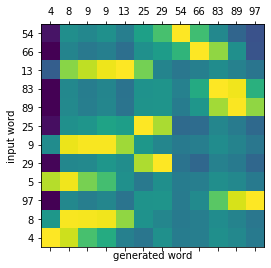

[ 7 59 67 63 66 78 27 54  4  4 68 17] [ 4  4  7 17 27 54 59 63 66 67 68 78] [ 4  7  7 17 27 54 59 63 63 66 68 78]

Attention matrix


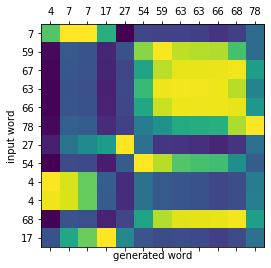

[87 52 86 62 19 51 11 46 61 69 45  5] [ 5 11 19 45 46 51 52 61 62 69 86 87] [ 5 11 19 45 46 52 51 62 61 69 87 86]

Attention matrix


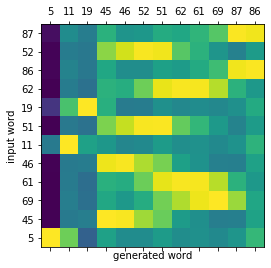

[ 8 75 11 43 49 45 22 68  2  1  1 19] [ 1  1  2  8 11 19 22 43 45 49 68 75] [ 1  1  8  8 11 19 22 43 45 49 68 75]

Attention matrix


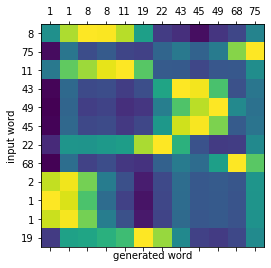

[91 81 23 56 46 53  8  6 69 72 61 61] [ 6  8 23 46 53 56 61 61 69 72 81 91] [ 6  8 23 46 53 56 61 61 69 72 81 91]

Attention matrix


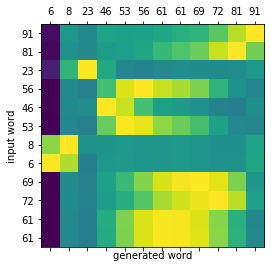

[42 58 94 85 79 31 94 43 44 71 61 33] [31 33 42 43 44 58 61 71 79 85 94 94] [31 33 42 43 44 58 61 71 79 85 94 94]

Attention matrix


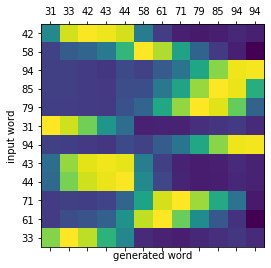

[14 93 13 50  7 41 43  2 26 75  2 84] [ 2  2  7 13 14 26 41 43 50 75 84 93] [ 2  7  7  7 13 26 41 43 50 75 84 93]

Attention matrix


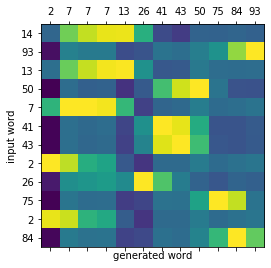

[15 66 14 92 53  2 20 68 69 85 76 51] [ 2 14 15 20 51 53 66 68 69 76 85 92] [ 2 14 15 20 51 53 66 66 69 76 85 92]

Attention matrix


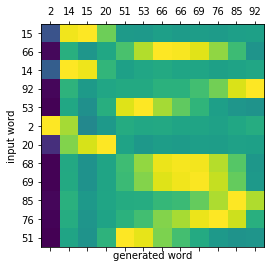

[67 91 58 46 45  3 92 25 72 18 65 28] [ 3 18 25 28 45 46 58 65 67 72 91 92] [ 3 18 25 28 45 46 58 65 67 72 91 92]

Attention matrix


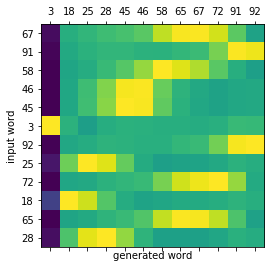

[35 47  6 42 49 63 83 81 67 77 10 35] [ 6 10 35 35 42 47 49 63 67 77 81 83] [ 6 10 35 35 42 47 49 63 67 77 77 83]

Attention matrix


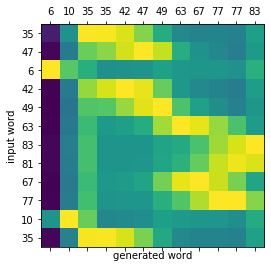

[93 73 60 54 69 30 74 31 20 74 94 69] [20 30 31 54 60 69 69 73 74 74 93 94] [20 30 31 54 60 69 69 73 74 74 93 94]

Attention matrix


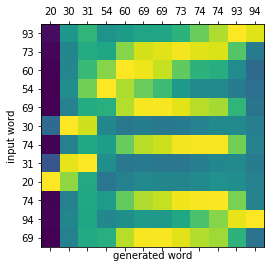

[ 1 49 89 29 45 95 50 96 68 77 41 36] [ 1 29 36 41 45 49 50 68 77 89 95 96] [ 1 29 36 41 45 49 50 68 77 89 89 96]

Attention matrix


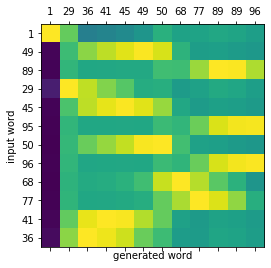

[40  2 16 75 72  2 75 38 20  0 49 96] [ 0  2  2 16 20 38 40 49 72 75 75 96] [ 0  2  2 16 20 38 40 49 72 75 75 96]

Attention matrix


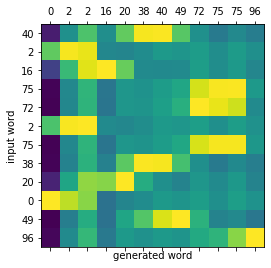

[62 23 32 55 32 10 29 48 41 32 84 81] [10 23 29 32 32 32 41 48 55 62 81 84] [10 23 29 32 32 32 41 48 55 62 81 84]

Attention matrix


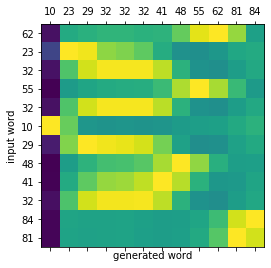

[82 36 13 24 33 78 17 21 44 47 28 32] [13 17 21 24 28 32 33 36 44 47 78 82] [13 17 21 24 28 32 32 36 44 47 78 82]

Attention matrix


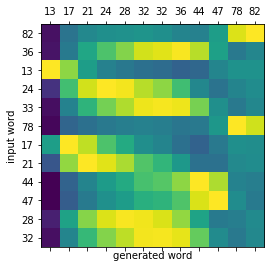

[64 68 54 95 70 87 68 25 29 74 36 59] [25 29 36 54 59 64 68 68 70 74 87 95] [25 29 36 54 59 64 64 68 70 74 87 95]

Attention matrix


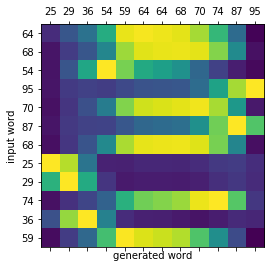

[ 6 55  8 35 93 91 61 34 22  7 42 75] [ 6  7  8 22 34 35 42 55 61 75 91 93] [ 6  7  8 22 34 35 42 55 61 75 91 93]

Attention matrix


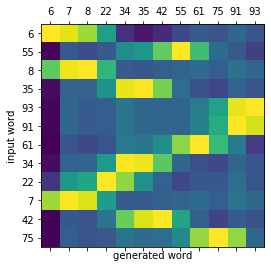

[92 84 42 97 20 98 91  7 62 17 30 10] [ 7 10 17 20 30 42 62 84 91 92 97 98] [ 7 10 17 20 30 42 62 84 92 91 91 98]

Attention matrix


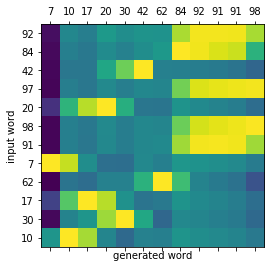

[98 93 64 56 91 87  8 54 94 69 91 73] [ 8 54 56 64 69 73 87 91 91 93 94 98] [ 8 54 56 64 69 73 87 91 93 93 93 98]

Attention matrix


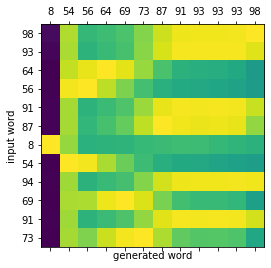

[81 60 21 32 55  3 39 73 72 60 31 93] [ 3 21 31 32 39 55 60 60 72 73 81 93] [ 3 21 31 32 39 55 60 60 72 73 81 93]

Attention matrix


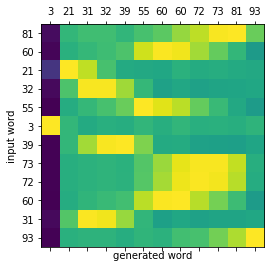

[45 58 81 23 77 92 14 64  5 40 85 98] [ 5 14 23 40 45 58 64 77 81 85 92 98] [ 5 14 23 40 45 58 64 77 81 85 92 98]

Attention matrix


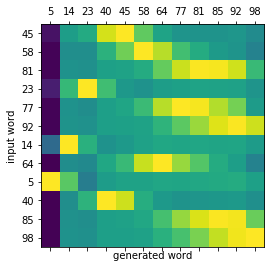

[16 94 26 14 84 40 15 17 19 10 89 28] [10 14 15 16 17 19 26 28 40 84 89 94] [10 10 14 16 19 19 26 28 40 84 84 94]

Attention matrix


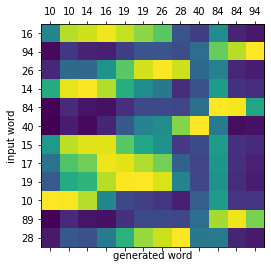

[55 24 69 59 91 14 95  9 89 29  3 31] [ 3  9 14 24 29 31 55 59 69 89 91 95] [ 3  9 14 24 29 31 55 59 69 89 89 95]

Attention matrix


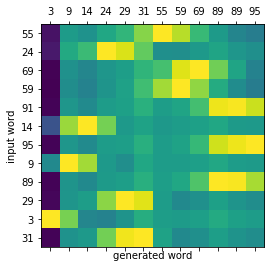

[81 16 52 49 95 45 87 76 97 35 88 83] [16 35 45 49 52 76 81 83 87 88 95 97] [16 35 45 49 52 76 76 81 88 88 95 97]

Attention matrix


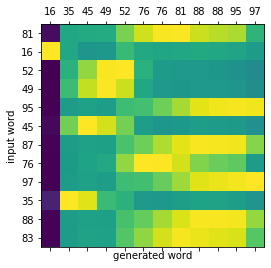

[12 26 45 63 85 59 75 40 90 76 70 98] [12 26 40 45 59 63 70 75 76 85 90 98] [12 26 40 45 59 63 70 75 76 85 90 98]

Attention matrix


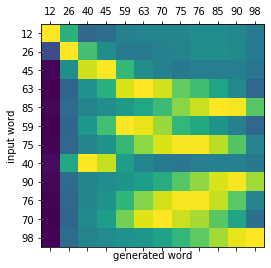

[94 25 61 52 95 22 84  8  0 85  8  4] [ 0  4  8  8 22 25 52 61 84 85 94 95] [ 0  4  8  8 22 25 52 61 84 84 94 95]

Attention matrix


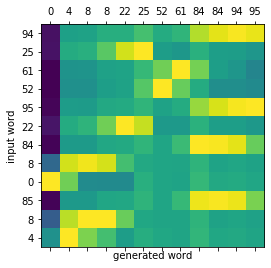

[53 93 90 49  7 86 64 83 83 14  7 65] [ 7  7 14 49 53 64 65 83 83 86 90 93] [ 7  7 14 49 53 64 65 83 83 86 90 93]

Attention matrix


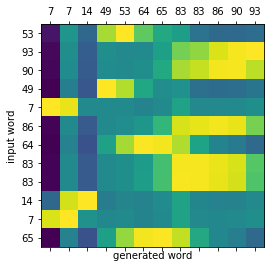

[65 72 37 61 75 79 92 11 90 76 81 46] [11 37 46 61 65 72 75 76 79 81 90 92] [11 37 46 61 65 72 75 79 79 79 90 92]

Attention matrix


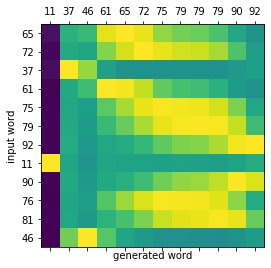

[21 34 61 98 18 87 53 19 83 53 98 77] [18 19 21 34 53 53 61 77 83 87 98 98] [18 21 34 34 53 53 61 77 83 87 87 98]

Attention matrix


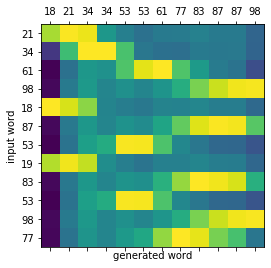

[36 60 39  9 83 85 80  2 77 23 68 47] [ 2  9 23 36 39 47 60 68 77 80 83 85] [ 2  9 23 36 39 47 60 68 77 77 80 85]

Attention matrix


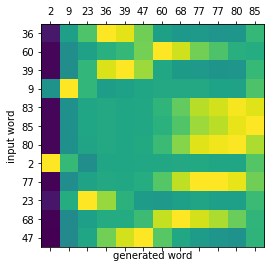

[67 36 51 18 61 49 27 76 63 93 24 66] [18 24 27 36 49 51 61 63 66 67 76 93] [18 24 27 36 49 51 61 63 66 67 76 93]

Attention matrix


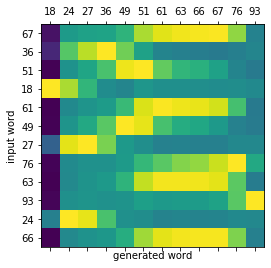

[87 29 18 99 22 99 48 82  8 52 40  5] [ 5  8 18 22 29 40 48 52 82 87 99 99] [ 5  8 18 22 29 40 48 52 82 87 99 99]

Attention matrix


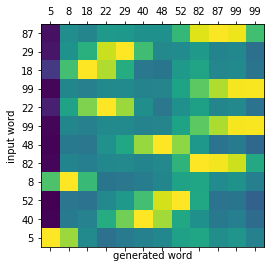

[12 93 44 83 42 96  1 53 80 90 93  0] [ 0  1 12 42 44 53 80 83 90 93 93 96] [ 0  1 12 42 44 53 80 83 90 90 90 96]

Attention matrix


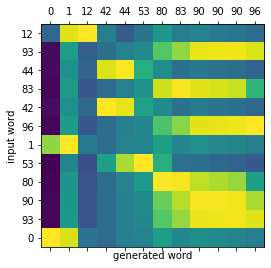

[32 95 78 97 51  4 35 81 85 94 43 59] [ 4 32 35 43 51 59 78 81 85 94 95 97] [ 4 32 35 43 51 59 78 78 85 85 94 97]

Attention matrix


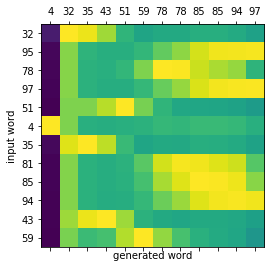

[21 43 35  2 64 14 63  6 89 96 12 69] [ 2  6 12 14 21 35 43 63 64 69 89 96] [ 2  6 12 14 21 35 43 63 64 69 89 96]

Attention matrix


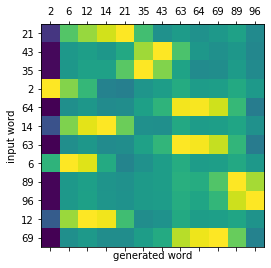

[ 8 28 95 97 44  8 29 62 47 19 29  0] [ 0  8  8 19 28 29 29 44 47 62 95 97] [ 0  8  8 19 28 29 29 44 47 62 95 97]

Attention matrix


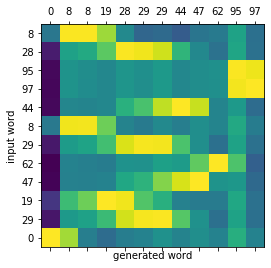

[87 79 93 62 27 38 15 56 17 92 91 31] [15 17 27 31 38 56 62 79 87 91 92 93] [15 17 27 31 38 56 62 79 87 91 91 93]

Attention matrix


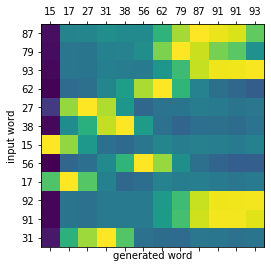

[81 72 14 19 85 99 87  2 88 56 10 36] [ 2 10 14 19 36 56 72 81 85 87 88 99] [ 2 10 14 19 36 56 72 81 85 87 88 99]

Attention matrix


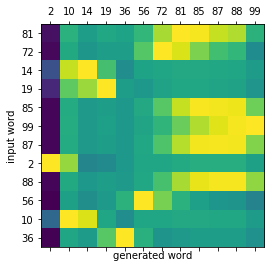

In [5]:

""" 
Pointer networks example
"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100]
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 50000
EPOCHS = 50


VALIDATION_RATIO = .2


def plot_attention(attention, input_word, generated_word, size_=(10,12)):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    plt.xlabel('generated word')
    plt.xticks(range(size_[0]),generated_word)
    plt.ylabel('input word')
    plt.yticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)
    # train-validate spilit
    ds_len = len(ds)
    indexes = list(range(ds_len))
    random.shuffle(indexes) # shuffle them
    spilit_spot = int(math.floor(VALIDATION_RATIO * ds_len))
    
    train_indexes = indexes[spilit_spot:]
    validation_indexes = indexes[:spilit_spot]

    # samples 
    train_sampler = SubsetRandomSampler(train_indexes)
    validation_sampler = SubsetRandomSampler(validation_indexes)

    # loaders
    train_dataloader = DataLoader(ds,
                            sampler=train_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)

    validation_dataloader = DataLoader(ds,
                            sampler=validation_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    


    # The Pointer Network model
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0005)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            _, sequence_length = batch.shape
            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #back propagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to check how store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()


    ################## Validation #############
    print('\nValidation ...\n')
    print('\ninput\ttarget\tpointer')
    pointer_network.eval()
    for batch, target_sequences in validation_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ignore last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])

     ################## Testing #############
    print('\n\n\n Testing of higher length 12')
    print('\ninput\ttarget\tpointer')
    ds = SortingDataset(range_=RANGE, lengths=[12], SOS_SYMBOL=SOS_SYMBOL, num_instances=100)
    test_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    for batch, target_sequences in test_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ingonre last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(12, 12))
            i += 1


if __name__ is '__main__':
    main()
